In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import imutils
import cv2
import glob
from matplotlib import cm


from google.colab import drive
drive.mount('/content/drive')

model = tf.keras.models.load_model('/content/drive/MyDrive/PROGETTO_CV&DL/model/my_eye_model_classification')
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                

In [12]:
def get_img_array(img_path, size):
	# `img` is a PIL image of size 299x299
	img = keras.preprocessing.image.load_img(img_path, target_size=size)
	# `array` is a float32 Numpy array of shape (299, 299, 3)
	array = keras.preprocessing.image.img_to_array(img)
	# We add a dimension to transform our array into a "batch"
	# of size (1, 299, 299, 3)
	array = np.expand_dims(array, axis=0)
	return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions
	grad_model = tf.keras.models.Model(
			[model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
	)

	# Then, we compute the gradient of the top predicted class for our input image
	# with respect to the activations of the last conv layer
	with tf.GradientTape() as tape:
			last_conv_layer_output, preds = grad_model(img_array)
			if pred_index is None:
					pred_index = tf.argmax(preds[0])
			class_channel = preds[:, pred_index]

	# This is the gradient of the output neuron (top predicted or chosen)
	# with regard to the output feature map of the last conv layer
	grads = tape.gradient(class_channel, last_conv_layer_output)

	# This is a vector where each entry is the mean intensity of the gradient
	# over a specific feature map channel
	pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

	# We multiply each channel in the feature map array
	# by "how important this channel is" with regard to the top predicted class
	# then sum all the channels to obtain the heatmap class activation
	last_conv_layer_output = last_conv_layer_output[0]
	heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
	heatmap = tf.squeeze(heatmap)

	# For visualization purpose, we will also normalize the heatmap between 0 & 1
	heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
	return heatmap.numpy()



def display_gradcam(img, heatmap, alpha=0.4):

	# Rescale heatmap to a range 0-255
	heatmap = np.uint8(255 * heatmap)

	# Use jet colormap to colorize heatmap
	jet = cm.get_cmap("jet")

	# Use RGB values of the colormap
	jet_colors = jet(np.arange(256))[:, :3]
	jet_heatmap = jet_colors[heatmap]

	# Create an image with RGB colorized heatmap
	jet_heatmap = array_to_img(jet_heatmap)
	jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
	jet_heatmap = img_to_array(jet_heatmap)

	# Superimpose the heatmap on original image
	superimposed_img = jet_heatmap * alpha + img
	superimposed_img = array_to_img(superimposed_img)

	return superimposed_img



In [13]:
def find_layer(model, layer_name):
    for (i, layer) in enumerate(model.layers):
        if layer.name == layer_name:
            return (i, layer)

submodel_index, submodel = find_layer(model, 'mobilenetv2_1.00_224')
x = submodel.outputs[0]
for layer_index in range(submodel_index+1, len(model.layers)):
    extracted_layer = model.layers[layer_index]
    print('Surgically appending layer : '+str(extracted_layer))
    x = extracted_layer(x)
unpacked_model = Model(inputs=submodel.inputs, outputs=[x])
unpacked_model.summary()

Surgically appending layer : <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb9251e8550>
Surgically appending layer : <keras.layers.core.dropout.Dropout object at 0x7fb9251e8b90>
Surgically appending layer : <keras.layers.core.dense.Dense object at 0x7fb9251ed5d0>
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (Bat

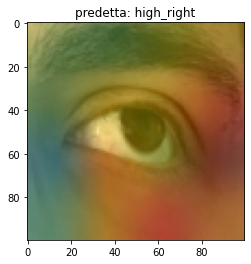

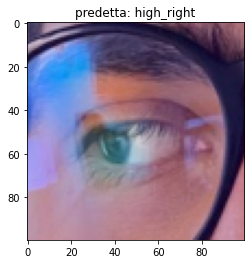

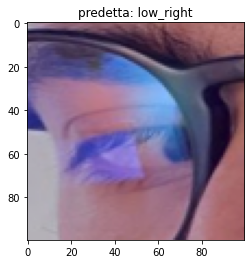

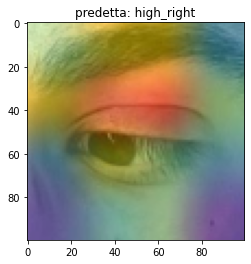

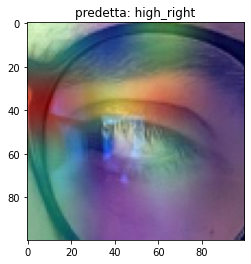

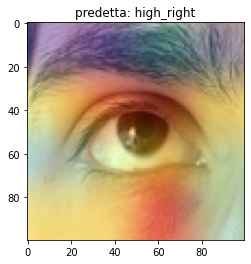

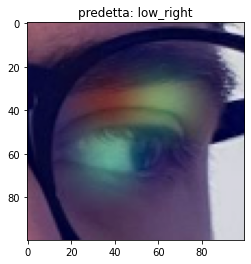

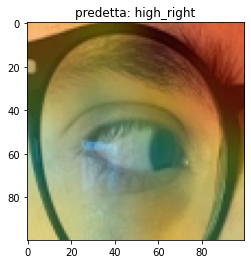

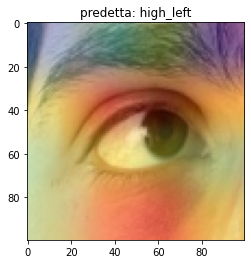

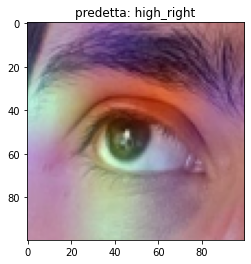

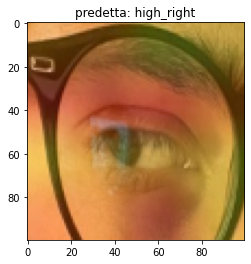

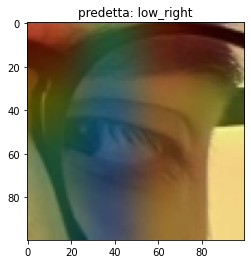

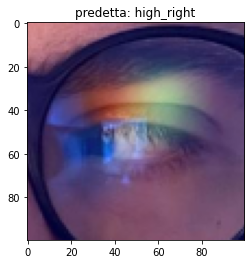

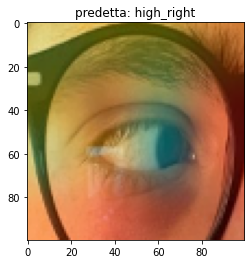

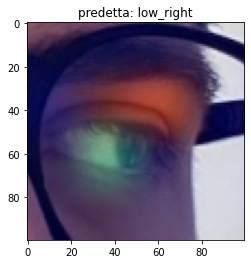

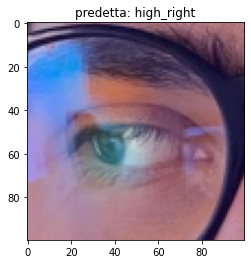

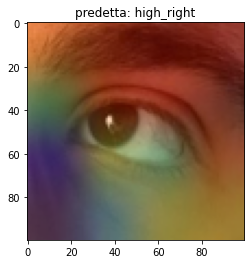

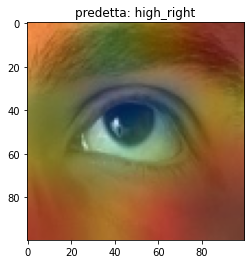

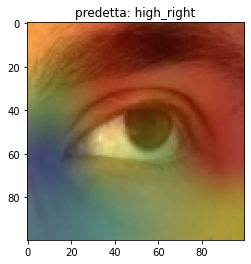

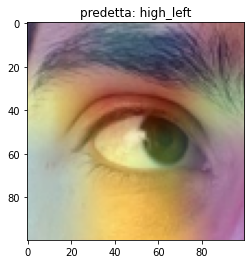

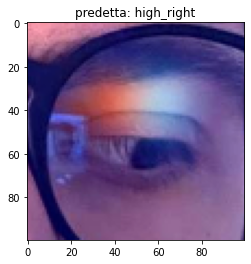

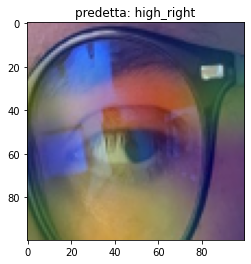

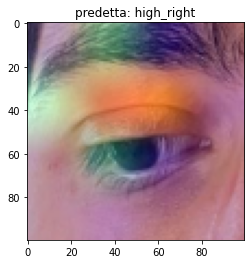

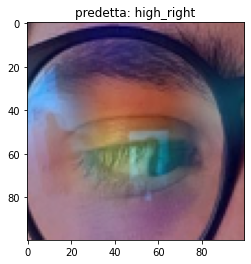

In [52]:
list_of_dirs = glob.glob('/content/drive/MyDrive/PROGETTO_CV&DL/dataset/test/real/*')
class_names = ['high_center', 'high_left', 'high_right', 'low_center', 'low_left', 'low_right', 'middle_center', 'middle_left', 'middle_right']

for item in list_of_dirs:
  #print(item)
  img = cv2.imread(item) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resized = cv2.resize(img, (100,100), interpolation=cv2.INTER_CUBIC)

  img_r = np.expand_dims(resized, axis=0)

  predictions = model.predict_on_batch(img_r)

  predictions = tf.nn.sigmoid(predictions).numpy()

  class_predicted = np.argmax(predictions[0])

  heatmap = make_gradcam_heatmap(img_r, unpacked_model, 'Conv_1_bn')

  immagine_finale = display_gradcam(resized, heatmap)
  
  imgplot = plt.imshow(immagine_finale)
  plt.title('predetta: ' + class_names[class_predicted])
  plt.show()
